In [1]:
# workflow.py
import os
import sqlite3
from typing import TypedDict, List

from dotenv import load_dotenv
load_dotenv(override=True)

# -------------------- LLM & EMBEDDINGS --------------------
from langchain_openai import ChatOpenAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.messages import (
    BaseMessage, HumanMessage, AIMessage, SystemMessage
)
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

# -------------------- VECTOR STORE --------------------
from langchain_community.vectorstores import FAISS

# -------------------- LANGGRAPH --------------------
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver

# -------------------- SEARCH --------------------
from langchain_community.utilities import SerpAPIWrapper

# -------------------- MODELS --------------------
from pydantic import BaseModel, Field


# =========================================================
# MODEL SETUP
# =========================================================

def get_groq_llm():
    return ChatOpenAI(
        model="meta-llama/llama-4-scout-17b-16e-instruct",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7,
        max_tokens=2500,
    )


def get_gemini_embedding_model():
    return GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")


# =========================================================
# VECTORSTORE
# =========================================================

def get_vectorstore():
    embeddings = get_gemini_embedding_model()
    faiss_path = "/Users/sachinmishra/Desktop/LangGraph_Project_Based_Learning/faiss_index_financial"

    return FAISS.load_local(
        faiss_path,
        embeddings=embeddings,
        allow_dangerous_deserialization=True
    )


vectorstore = get_vectorstore()
retriever = vectorstore.as_retriever(search_kwargs={"k": 6})


# =========================================================
# PROMPTS
# =========================================================

llm = get_groq_llm()

rag_prompt = ChatPromptTemplate.from_template(
    """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration:

Chat History:
{history}

Context:
{context}

Question:
{question}
"""
)

rag_chain = rag_prompt | llm


off_topic_prompt = ChatPromptTemplate.from_template(
    """When a user asks an off-topic question (not related to JPM 2023 pdf/report or JPM SE Annual report/pdf ):

Provide a short, polite answer to acknowledge their query.

Immediately and firmly remind the user that you are built specifically for finance-related queries.

Encourage them to return to finance-related questions, since that’s where you can provide real value.

If relevant, use the chat history to make your reminder more natural and connected to past discussions.

Always maintain a friendly but professional tone.

Chat history:
{history}

Question:
{question}
"""
)

off_topic_rag_chain = off_topic_prompt | llm


# =========================================================
# STATE
# =========================================================

class AgentState(TypedDict):
    messages: List[BaseMessage]
    summary: str     # ✅ ADDED
    documents: List[Document]
    rephrased_question: str
    on_topic: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage
    sources: List[dict]   # ✅ ADDED
    current_step: str
    roles: List[str]  # ✅ ADDED


# =========================================================
# CLASSIFIERS
# =========================================================

class GradeQuestion(BaseModel):
    score: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )


class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )


# =========================================================
# NODES
# =========================================================


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")
    state["current_step"] = "Rewriting question..."

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0
    state.setdefault("sources", [])   # ✅ init
    state.setdefault("roles", ["analyst"])     # ✅ init

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = get_groq_llm()
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state


def question_classifier(state: AgentState):
    print("Entering question_classifier")
    state["current_step"] = "Classifying question topic..."
    system_message = SystemMessage(
        content=""" You are a classifier that determines whether a user's question is about one of the following Financial topics 
    
    
    1. About jp morgan chase & co and it's financial services/reports
    2. Any question related to stock market, investment, banking, finance, financial analysis, financial reports, financial services, economic trends, market analysis, investment strategies, financial planning, asset management, wealth management, corporate finance, personal finance, financial regulations, financial technology (fintech), or financial markets.
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """
    )

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = get_groq_llm()
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state


def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    state["current_step"] = "Routing question..."
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"


# def retrieve(state: AgentState):
#     print("Entering retrieve")
#     state["current_step"] = "Retrieving documents from FAISS Vectorstore..."
#     documents = retriever.invoke(state["rephrased_question"])
#     print(f"retrieve: Retrieved {len(documents)} documents")
#     state["documents"] = documents
#     return state

def retrieve(state: AgentState):
    print("Entering retrieve")
    state["current_step"] = "Retrieving documents from FAISS Vectorstore..."

    query = state["rephrased_question"]
    allowed_roles = set(state.get("roles", []))

    # Step 1: Retrieve top-K from FAISS
    docs = retriever.invoke(query)
    print(f"retrieve: Retrieved {len(docs)} raw documents")

    # Step 2: Apply role-based filtering
    if allowed_roles:
        filtered_docs = []
        for doc in docs:
            role = (doc.metadata or {}).get("role")
            if role in allowed_roles:
                filtered_docs.append(doc)

        print(
            f"retrieve: {len(filtered_docs)} documents left "
            f"after role filtering ({allowed_roles})"
        )
    else:
        filtered_docs = docs

    state["documents"] = filtered_docs
    return state



def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    state["current_step"] = "Grading retrieved documents..."
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    llm = get_groq_llm()
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state


def proceed_router(state: AgentState):
    print("Entering proceed_router")
    state["current_step"] = "Routing to next step..."
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "search_internet"
    else:
        print("Routing to refine_question")
        return "refine_question"


def refine_question(state: AgentState):
    print("Entering refine_question")
    state["current_step"] = "Refining question for better retrieval..."
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="""You are a helpful JPM financial assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = get_groq_llm()
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state


# =========================================================
# 🔥 SOURCES ADDED HERE
# =========================================================

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    state["current_step"] = "Generating final answer..."
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    # history = state["messages"]
    history = []

    if state.get("summary"):
        history.append(
            SystemMessage(content=f"Conversation summary:\n{state['summary']}")
        )

    history.extend(state["messages"])

    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_question}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")


    # ✅ Extract sources from documents
    sources = []
    for doc in state["documents"]:
        meta = doc.metadata or {}
        sources.append({
            "file_name": meta.get("file_name", "Unknown"),
            "role": meta.get("role", "Unknown"),
            "page": meta.get("page", None)
        })

    # Deduplicate
    unique_sources = {
        (s["file_name"], s["role"], s["page"]): s
        for s in sources
    }.values()

    return {
        "messages": state["messages"] + [AIMessage(content=generation)],
        "sources": list(unique_sources)
    }


def search_internet(state: AgentState):
    print("Entering search_internet")
    state["current_step"] = "Searching the internet for answers..."
    search = SerpAPIWrapper()
    raw_results = search.run(state["rephrased_question"])

    # Convert list → readable string
    if isinstance(raw_results, list):
        search_text = "\n".join(raw_results)
    else:
        search_text = str(raw_results)

    # Ask LLM to extract a clean answer
    llm = get_groq_llm()
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(
            content="""You are a financial assistant.
            summarize the internet search results to answer the user's question concisely and accurately.
            """
        ),
        HumanMessage(
            content=f"""
            Question: {state["rephrased_question"]}

            Internet search results:
            {search_text}
            """
        )
        ])  

    response = (prompt | llm).invoke({})
    clean_answer = response.content.strip()

    return {
        "messages": state["messages"] + [AIMessage(content=clean_answer)],
        "sources": [
            {"file_name": "Internet Search", "role": "search", "page": None}
        ]
    }



def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    state["current_step"] = "Generating off-topic response..."
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    response = off_topic_rag_chain.invoke({
        "history": state["messages"],
        "question": state["rephrased_question"]
    })
    return {
        "messages": state["messages"] + [AIMessage(content=response.content.strip())],
        "sources": []
    }


def summarize_conversation(state: AgentState):
    print("Entering summarize_conversation")
    state["current_step"] = "Summarizing conversation..."

    existing_summary = state.get("summary", "")

    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Update and extend this summary using the conversation above."
        )
    else:
        prompt = "Summarize the conversation above concisely."

    llm = get_groq_llm()
    response = llm.invoke(
        state["messages"] + [HumanMessage(content=prompt)]
    )

    # 🔥 KEEP only last 2 messages
    trimmed_messages = state["messages"][-3:]

    state["summary"] = response.content.strip()
    state["messages"] = trimmed_messages

    return state

## helper - When to summarize

def should_summarize(state: AgentState):
    return len(state["messages"]) > 8





In [2]:
sqlite_conn = sqlite3.connect("financebot.sqlite", check_same_thread=False)
checkpointer = SqliteSaver(sqlite_conn)

In [3]:
# =========================================================
# GRAPH
# =========================================================

def build_graph():

    g = StateGraph(AgentState)

    g.add_node("question_rewriter", question_rewriter)
    g.add_node("question_classifier", question_classifier)
    g.add_node("off_topic_response", off_topic_response)
    g.add_node("retrieve", retrieve)
    g.add_node("retrieval_grader", retrieval_grader)
    g.add_node("generate_answer", generate_answer)
    g.add_node("refine_question", refine_question)
    g.add_node("summarize_conversation", summarize_conversation)
    g.add_node("search_internet", search_internet)    

    g.add_edge("question_rewriter", "question_classifier")
    g.add_conditional_edges(
        "question_classifier",
        on_topic_router,
        {
            "retrieve": "retrieve",
            "off_topic_response": "off_topic_response",
        },
    )

    g.add_edge("retrieve", "retrieval_grader")
    g.add_conditional_edges(
        "retrieval_grader",
        proceed_router,
        {
            "generate_answer": "generate_answer",
            "refine_question": "refine_question",
            "search_internet": "search_internet",
        },
    )

    # 🔥 CONDITIONAL SUMMARY
    g.add_conditional_edges(
        "generate_answer",
        should_summarize,
        {
            True: "summarize_conversation",
            False: END,
        }
    )

    g.add_edge("refine_question", "retrieve")
    g.add_edge("search_internet", "summarize_conversation")
    g.add_edge("summarize_conversation", END)
    #g.add_edge("generate_answer", END)
    g.add_edge("off_topic_response", END)
    g.set_entry_point("question_rewriter")
    graph = g.compile(checkpointer=checkpointer)
    return graph



In [4]:
graph= build_graph()

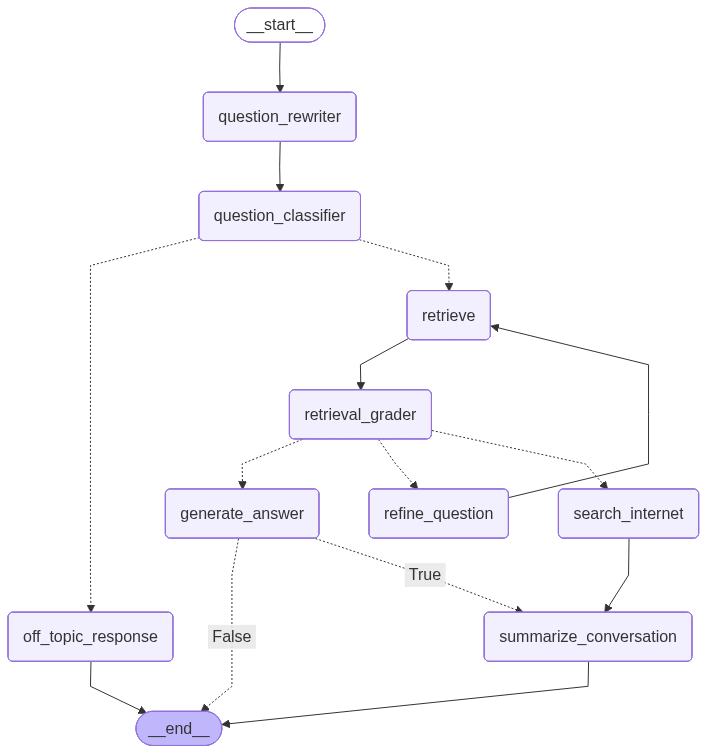

In [5]:
graph

In [24]:
def get_graph():
# Workflow
    workflow = StateGraph(AgentState)
    workflow.add_node("question_rewriter", question_rewriter)
    workflow.add_node("question_classifier", question_classifier)
    workflow.add_node("off_topic_response", off_topic_response)
    workflow.add_node("retrieve", retrieve)
    workflow.add_node("retrieval_grader", retrieval_grader)
    workflow.add_node("generate_answer", generate_answer)
    workflow.add_node("refine_question", refine_question)
    workflow.add_node("summarize_conversation", summarize_conversation)
    workflow.add_node("search_internet", search_internet)

    workflow.add_edge("question_rewriter", "question_classifier")
    workflow.add_conditional_edges(
        "question_classifier",
        on_topic_router,
        {
            "retrieve": "retrieve",
            "off_topic_response": "off_topic_response",
        },
    )
    workflow.add_edge("retrieve", "retrieval_grader")
    workflow.add_conditional_edges(
        "retrieval_grader",
        proceed_router,
        {
            "generate_answer": "generate_answer",
            "refine_question": "refine_question",
            "search_internet": "search_internet",
        },
    )
    #🔥 CONDITIONAL SUMMARY
    workflow.add_conditional_edges(
        "generate_answer",
        should_summarize,
        {
            True: "summarize_conversation",
            False: END,
        }
    )
    workflow.add_edge("refine_question", "retrieve")
    workflow.add_edge("search_internet", "summarize_conversation")
    workflow.add_edge("summarize_conversation", END)
    #workflow.add_edge("cannot_answer", "search_internet")
    workflow.add_edge("off_topic_response", END)
    workflow.set_entry_point("question_rewriter")
    graph = workflow.compile(checkpointer=checkpointer)
    return graph

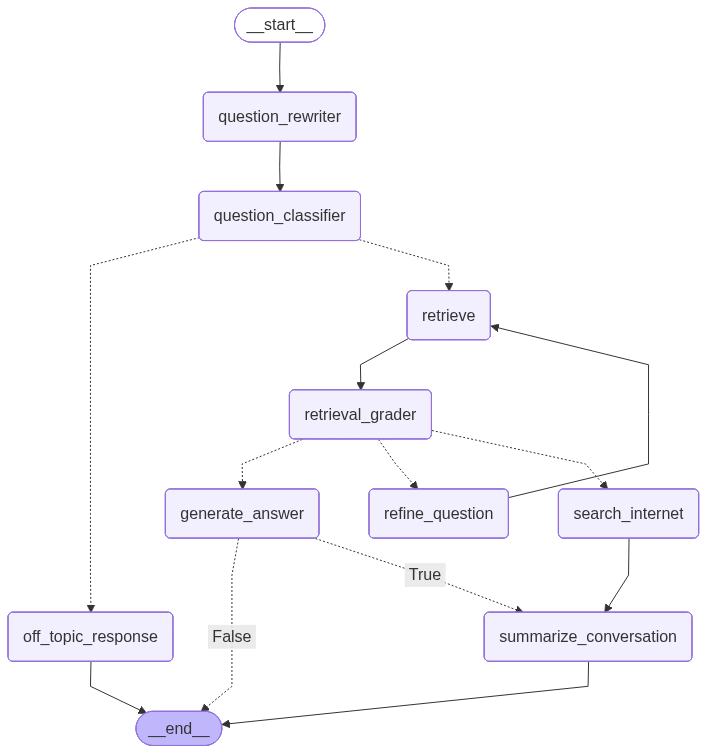

In [25]:
graph = get_graph()
graph